Etude de la hauteur d'une figure :
- Idée naive : 
    Intégrer 2 fois acceleration dans repere G -> pas top bcp de bruit + gravite compliqué a enlever
- Idee "physique": 
    Se baser sur equation horaire de mouvement d'un objet cf : https://fr.khanacademy.org/science/physique-a-l-ecole/x6e8a541a302cdab5:physique-a-l-ecole-5e-annee-secondaire-1h/x6e8a541a302cdab5:physique-a-l-ecole-5e-1h-mouvement-rectiligne-uniformemement-accelere-mrua/v/deriving-max-projectile-displacement-given-time
    On peut obtenir pic de décollage et d'atterrissage de la figure => besoin du temps de vol
    Avec le temps de vol : $ Hmax = \frac{a \cdot dt^2}{8} \; avec \; a  \; la \; gravite$

=> Objectif : trouver temps de vol
    Methode de detection de pic :
        - scipi.pic
        - Regularisation du signal d'acceleration z pour le rendre sparse puis pic
        - convolution avec dirac


Utilisation de la matrice de rotation du skate:
https://thepoorengineer.com/en/quaternion/

In [55]:
import os
import sys

print(sys.path)
if '\\Users\\Pierre\\Documents\\GitHub\\SkateboardXXX3000\\01_Python\\MovuinoDataHandler\\' not in sys.path:
    sys.path.append('\\Users\\Pierre\\Documents\\GitHub\\SkateboardXXX3000\\01_Python\\MovuinoDataHandler\\')
    print("ok")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

import movuinos.SkateboardXXX3000DataSet as sk
import tools.display_functions as df
import tools.signal_analysis as sa
import tools.integratino_functions as ifct
import tools.correction_interpolation as ci

import models.detection.detection_energy as dt
import models.classification.reference_tricks_classification as rtc

from pathlib import Path

from tools.quaternion import Quaternion#, get_euler_angles, get_rot_mat

['c:\\Users\\Pierre\\Documents\\GitHub\\SkateboardXXX3000\\01_Python\\MovuinoDataHandler\\study', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\python37.zip', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\DLLs', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\lib', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler', '', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\lib\\site-packages', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\lib\\site-packages\\win32', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Pierre\\anaconda3\\envs\\MovuinoDataHandler\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Pierre\\.ipython', '\\Users\\Pierre\\Documents\\GitHub\\SkateboardXXX3000\\01_Python\\MovuinoDataHandler\\']


In [56]:
tricks_path = "../../../06_Data/Isolated_Tricks/ollie/ollie_success_2.csv"
tricks_path = "../../../06_Data/sequences/data_test/record_3_interpolated.csv"

print(Path(tricks_path).exists())
print(Path(tricks_path).glob(pattern="*"))
#--- Opening file ---
print("Opening : " + tricks_path)
trick = sk.SkateboardXXX3000DataSet(tricks_path)

True
<generator object Path.glob at 0x0000018F7BEF69C8>
Opening : ../../../06_Data/sequences/data_test/record_3_interpolated.csv
Reading : ../../../06_Data/sequences/data_test/record_3_interpolated.csv


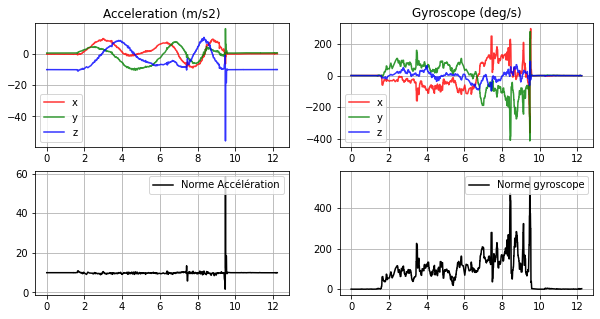

In [57]:
plt.figure(figsize=(10,5))
trick.dispRawData()

[-0.  0. -0.]
[ 1.04685981  0.05878089  0.11464056 -0.0052105 ]
[[ 1.08620105  0.02438668  0.23941263]
 [ 0.00256801  1.10557558 -0.12426537]
 [-0.24063774  0.12187603  1.07934496]]
[[ 1.08620105  0.02438668  0.23941263]
 [ 0.00256801  1.10557558 -0.12426537]
 [-0.24063774  0.12187603  1.07934496]]


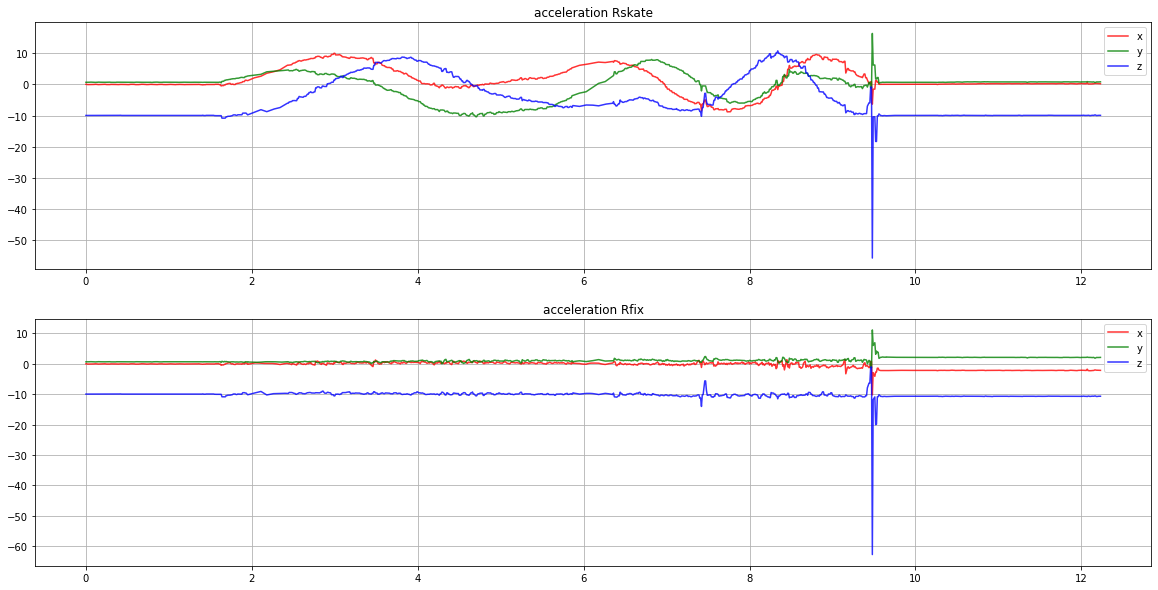

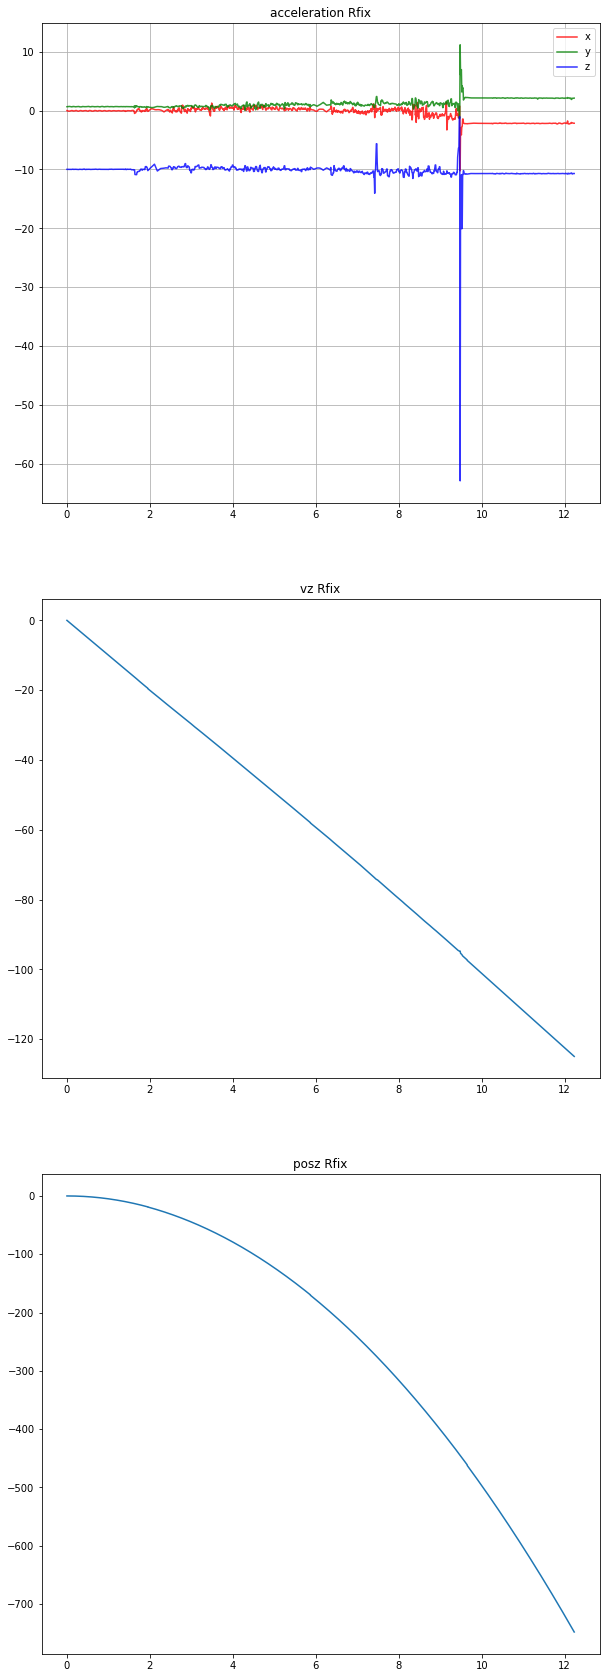

(1227, 3, 3)


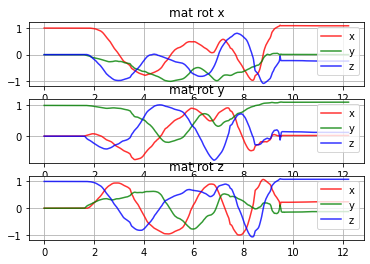

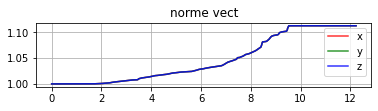

In [58]:
quaternion=Quaternion()
print(trick.gyroscope[:,100])
a_fixes=[]
N=[]
q=[]
for i in range(trick.nb_row):
    quaternion.rotate(trick.gyroscope[:,i]*np.pi/180,trick.Te)

    rot =quaternion.get_rot_mat()
    q.append(rot.T)
    n=np.linalg.norm(rot,axis=1)
    N.append(n)
    a_fixe=np.matmul(rot, trick.acceleration[:,i])
    # a_fixe[2]-=10
    a_fixes.append(a_fixe)

print(quaternion.q)
print(quaternion.get_rot_mat())

print(rot)
a_fixes=np.array(a_fixes)
# a_fixes=trick.acceleration
vz_fixes=ifct.EulerIntegration(a_fixes[:,2],trick.Te)
posz_fixes=ifct.EulerIntegration(vz_fixes,trick.Te)

vy_fixes=ifct.EulerIntegration(a_fixes[:,1],trick.Te)
posy_fixes=ifct.EulerIntegration(vy_fixes,trick.Te)

vx_fixes=ifct.EulerIntegration(a_fixes[:,0],trick.Te)
posx_fixes=ifct.EulerIntegration(vx_fixes,trick.Te)

plt.figure(figsize=(20,10))
df.plotVector(trick.time,trick.acceleration.T,"acceleration Rskate",211)
df.plotVector(trick.time,a_fixes,"acceleration Rfix",212)

plt.figure(figsize=(10,30))
df.plotVector(trick.time,a_fixes,"acceleration Rfix",311)
plt.subplot(312)
plt.plot(trick.time,vz_fixes[:])
plt.title("vz Rfix")
plt.subplot(313)
plt.plot(trick.time,posz_fixes[:])
plt.title("posz Rfix")
plt.show()

N=np.array(N)
q=np.array(q)
print(q.shape)
df.plotVector(trick.time, q[:,0],"mat rot x",311)
df.plotVector(trick.time, q[:,1],"mat rot y",312)
df.plotVector(trick.time, q[:,2],"mat rot z",313)
plt.show()

df.plotVector(trick.time,N,"norme vect",311)
plt.show()

c:\Users\Pierre\anaconda3\envs\MovuinoDataHandler\lib\site-packages\ipykernel_launcher.py:6: PeakPropertyWarning: some peaks have a prominence of 0
  


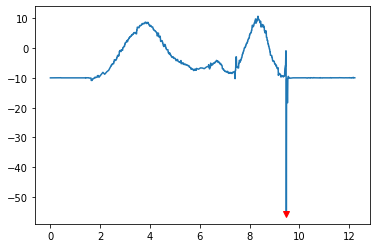

IndexError: index 1 is out of bounds for axis 0 with size 1

In [59]:
az= trick.acceleration[2,:]

prominence = 15
distance =5

peaks_acc, _acc = find_peaks(np.abs(az), prominence=prominence, distance=distance,wlen=10)
# print(az.shape)
time_peak = np.array(trick.time)[peaks_acc]

plt.plot(trick.time,az)
plt.plot(time_peak,az[peaks_acc],"v", color="r", label="Peaks")

plt.show()

dt=float(time_peak[1]-time_peak[0])

Hmax = 1.226*dt**2

print("dt : ",dt)
print("Hauteur tricks : ", Hmax)

In [ ]:
peaks_acc.shape


(6,)